# Analisis de posibilidad de join entre datos sernapesca

### Import libreries

In [20]:
import logging
import subprocess
import os   
import pandas as pd
import seaborn as sns
from datetime import datetime, timedelta, date
import pendulum
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

In [73]:
%%time
reporte_plantas_raw = pd.read_excel("../data/datos_sernapesca/Reporte de Plantas.xlsx")
ingresos_raw = pd.read_excel("../data/datos_sernapesca/Ingresos 2021-2022.xlsx")
RNA_raw = pd.read_excel("../data/datos_sernapesca/RNA.XLSX")
listado_plantas = pd.read_excel("../data/datos_sernapesca/Listado de plantas.xlsx")

CPU times: user 41.8 s, sys: 109 ms, total: 41.9 s
Wall time: 42.1 s


### Filtrando por región y tipo de producto

In [66]:
# Se filtra por region, no es necesario hacer filtro por producto ya que solo se encuentra 
# info disponible para moluscos
reporte_plantas_filtered = reporte_plantas_raw[(reporte_plantas_raw['Región Bodega'] == 'X REGION') |
                                        (reporte_plantas_raw['Región Agente'] == 'X REGION') |
                                        (reporte_plantas_raw['Tipo Ult. Proveedor'] == 'CC')]
reporte_plantas_filtered = reporte_plantas_filtered.reset_index()          
# columnmas a eliminar.
to_drop = ['Región Agente',
           'Fecha Declaración',
           'Nº Declaración',
           'idStock',
           'Tipo Item',
           'Estado Recurso',
           'Folio Origen',
           'Tipo Ult. Proveedor',
           'Folio Ult. Proveedor',
           'utilizado',
           'Unidades Rest',
           'Unidades Abastecidas',
           'Tipo Declaración',
           'idBodega',
           'Nombre Bodega']
# eliminando columnas que no sirven.
reporte_plantas_filtered = reporte_plantas_filtered.drop(to_drop, axis=1)


# Se filtra sólo por tipo de especie = molusco, ya que este dataset ya era sólo de la décima región
ingresos_filtered = ingresos_raw[ingresos_raw['Tipo Especie'] == 'MOLUSCOS']
# columnmas a eliminar.
to_drop = ['ACS',
            'Región',
            'N° Declaración',
            'Tipo Especie',
            'Sistema Ingreso']
# eliminando columnas que no sirven.
ingresos_filtered = ingresos_filtered.drop(to_drop, axis=1)


# El registro nacional de acuicultura de sernapesca (RNA) se encuentra para todo chile, por lo que se filtra
# para la décima región. También se filtra por aquellos centros que se encuentran inscritos.
RNA_filtered = RNA_raw[(RNA_raw['Región'] == 10) & 
                       (RNA_raw['Categoria'] == 'INSCRITO')]

In [23]:
# se imprimen las formas de los dataset a analizar
shape_reportes =  reporte_plantas_filtered.shape
shape_ingresos =  ingresos_filtered.shape
shape_RNA =  RNA_filtered.shape
print(f'''El dataset de reportes filtrado tiene una forma {shape_reportes}, 
        mientras que el de ingresos es de la forma {shape_ingresos} y 
        el de RNA es de {shape_RNA}''')

El dataset de reportes filtrado tiene una forma (53974, 21), 
        mientras que el de ingresos es de la forma (7998, 17) y 
        el de RNA es de (2338, 18)


Se tienen 3 datasets y queremos saber si es que es posible hacer join entre los 3. Para esto y en primera instancia es necesario definir los campos que podrían ser utilizados para el join. 

* Por parte de la tabla de ingresos, existe el codigo de centro y el codigo de origen, los cuales podrían servir.

* Para el caso de la tabla de reportes, código de agente parece ser una buena opción y también código del último proovedor.

* Finalmente la tabbla de RNA contiene el código del centro de cultivo acuícola.

### Cúal es la producción actual de las plantas?

In [24]:
reporte_plantas_filtered
ingresos_filtered
RNA_filtered

,Región,Sector,Nm_Provincia,Comuna Centro,Nombre Area,Codigo Centro,Nombre Centro,Categoria,N° Folio RNA,Rut,Propietario,Dirección,Comuna Propietario,Tipo Cultivo,Cuerpo de Agua,Latitud,Longitud,Tipo Propietario
684,10,RÌO PUDETO,Chiloé,Ancud,NaN,100009,*,INSCRITO,624.0,84913200-8,"ANCUD LTDA.,COOPERATIVA DE PESCADORES",LIBERTAD 669 OF.307,Ancud,CERRADO,PUDETO,41.883533,73.754700,Sindicato
687,10,"ESTERO CHOPE, ISLA PULUQUI, SECTOR 1",Llanquihue,Calbuco,NaN,100019,*,INSCRITO,6981.0,69220600-2,"MUNICIPALIDAD DE CALBUCO, ILUSTRE","ERRAZURIZ 210, CALBUCO",Calbuco,CERRADO,NaN,41.815892,73.077834,Municipalidad
689,10,CALETA RILAN,Chiloé,Castro,NaN,100022,ENSENADA RILAN,INSCRITO,3162.0,84764200-9,"APIAO S.A., EMPRESA PESQUERA","AV. APOQUINDO N°4501, OF. 1603, L.CONDES",Las Condes,CERRADO,NaN,42.534755,73.633812,Empresa
691,10,"ESTERO CHOPE, ISLA PULUQUI",Llanquihue,Calbuco,NaN,100024,*,INSCRITO,0.0,7928655-9,MIRANDA VELASQUEZ JUAN PEDRO,O HIGGINS 167 OF 403,Puerto Montt,CERRADO,NaN,NaN,NaN,Persona Natural
699,10,ESTERO CHOPE,Llanquihue,Calbuco,NaN,100044,CHOPE I,INSCRITO,811.0,6856865-K,YOKOTA BEURET EUGENIO RAUL,AV. BRASIL 710,Calbuco,CERRADO,CHOPE,41.814208,73.089875,Persona Natural
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5754,10,AAMERB BALTAZAR,Palena,Hualaihué,NaN,810248,AAMERB - BALTAZAR,INSCRITO,0.0,65305390-8,"S.T.I.B.M.P.A. Y R.S. ""PICHICOLO""","21 DE SEPTIEMBRE S/N, HORNOPIRÉN",Hualaihué,AAMERB,NaN,42.103725,72.587475,Sindicato
5755,10,"PASO QUILOLCURA, NORTE PUNTA LILECURA, ISLA QUENU",Llanquihue,Calbuco,NaN,810262,AAMERB - ISLA QUENU SECTOR B,INSCRITO,0.0,65091450-3,"S.T.I.P.A.A.M. Y R.S. ""EULOGIO GOYCOLEA GARAY""","AV. BRASIL S/N°, VILLA ESPERANZA",Calbuco,AAMERB,NaN,41.820361,73.145026,Sindicato
5756,10,ESTERO PICHICOLO,Palena,Hualaihué,NaN,810276,AAMERB - ESTE PUNTILLA PICHICOLU,INSCRITO,0.0,65260290-8,"S.T.I., PESC. ART., BZ. MARISC. Y RAM. S., UNI...","CALLLE 21 DE SEPTIEMBRE S/N, HORNOPIREN",Hualaihué,AAMERB,NaN,42.015438,72.606775,Sindicato
5757,10,"CANAL DESERTORES, NORTE CALETA CHANA",Palena,Chaitén,NaN,810286,AAMERB - CHANA SECTOR B,INSCRITO,0.0,74053200-6,"S.T.I., PESC. ARTESANALES Y ALGUEROS DE CHANA",SECTOR CHANA RURAL S/N,Chaitén,AAMERB,NaN,42.730595,72.846326,Sindicato


In [25]:
# se define una fecha a consultar
date_to_consult = '2022-06-30'
# se definen los dias a analizar
days_to_track = 30
# se transforma a dato tipo date
date_to_consult = datetime.strptime(date_to_consult, '%Y-%m-%d')
# la fecha de inicio = fecha a consultar - dias a analizar
start_date =  date_to_consult - timedelta(days=days_to_track)
# Se filtra para las fechas definidas anteriormente
reporte_plantas_last_month = reporte_plantas_filtered[(reporte_plantas_filtered['Fecha Ult. Proveedor'] > start_date) & 
                                                      (reporte_plantas_filtered['Fecha Ult. Proveedor'] < '2022-06-30')]
# Se agrupa para conocer la sumatoria de toneladas abastecidas
# por centro de cultivo (independiente de la planta)
reporte_plantas_last_month_sum = reporte_plantas_last_month[['Código Agente','Toneladas Abastecidas']].groupby('Código Agente').sum()
reporte_plantas_last_month_sum

,Toneladas Abastecidas
Código Agente,
3061,14.372
3150,9.343
4153,18.836
5251,7.441
8320,2.670
8476,12.000
10034,2039.300
10213,47.762
10217,3302.865


In [26]:
ingresos_filtered


,Codigo Centro,Propietario,Nombre Sector,Tipo Cultivo,Tipo Agua,Año,Mes,Provincia,Comuna,Cod. Especie,Especie,Etapa,Unidades,Kilos,Origen,Cod. Origen,Nombre Origen
53983,101004,SOCIEDAD LA BOTICA LTDA.,"ENSENADA NAGLE, ESTE DE PUNTA AUCAN",CERRADO,Mar,2021,1,Chiloé,Ancud,480,OSTRA CHILENA,SEMILLAS,132000.0,1100.0,Otros,1.0,CAPTACION NATURAL
53984,101422,"SANCHEZ MIRANDA, RUBEN SEGUNDO","LECAM, BAHIA LINAO",CERRADO,Mar,2021,1,Chiloé,Ancud,430,CHORITO,SEMILLAS,NaN,1932.0,Otros,6.0,PERMISO DE ESCASA IMPORTANCIA
54005,102109,INVERSIONES COIHUIN LTDA.,BAHIA LINAO,CERRADO,Mar,2021,1,Chiloé,Ancud,430,CHORITO,SEMILLAS,NaN,3000.0,Centro de Cultivo,102810.0,BAEZ MALDONADO JUAN HOMERO
54006,102109,INVERSIONES COIHUIN LTDA.,BAHIA LINAO,CERRADO,Mar,2021,1,Chiloé,Ancud,430,CHORITO,SEMILLAS,NaN,3000.0,Centro de Cultivo,102810.0,BAEZ MALDONADO JUAN HOMERO
54007,102109,INVERSIONES COIHUIN LTDA.,BAHIA LINAO,CERRADO,Mar,2021,1,Chiloé,Ancud,430,CHORITO,SEMILLAS,NaN,4000.0,Centro de Cultivo,102810.0,BAEZ MALDONADO JUAN HOMERO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64047,103763,INVERSIONES COIHUIN LTDA.,"BAHIA HUELMO, ESTE PUNTA CONCHA BLANCA",CERRADO,Mar,2022,6,Llanquihue,Puerto Montt,430,CHORITO,SEMILLAS,NaN,25000.0,Centro de Cultivo,102358.0,INVERSIONES COIHUIN LTDA.
64048,103763,INVERSIONES COIHUIN LTDA.,"BAHIA HUELMO, ESTE PUNTA CONCHA BLANCA",CERRADO,Mar,2022,6,Llanquihue,Puerto Montt,430,CHORITO,SEMILLAS,NaN,20000.0,Área de Manejo,10208.0,Weste Isla Pelada Sector B
64049,104092,INVERSIONES COIHUIN LTDA.,"ESTE PUNTA CAPACHO, BAHIA ILQUE",CERRADO,Mar,2022,6,Llanquihue,Puerto Montt,430,CHORITO,SEMILLAS,NaN,17604.0,Área de Manejo,10207.0,Weste Isla Pelada Sector A
64052,103610,SOCIEDAD ACUI CHOLMAR SPA,"CANAL LLANCAHUE, SURESTE ISLA MUTRI",CERRADO,Mar,2022,6,Palena,Hualaihué,430,CHORITO,SEMILLAS,NaN,96000.0,Otros,1.0,CAPTACION NATURAL


In [27]:
#ingresos_filtered

RNA_list_CCAA = RNA_filtered['Codigo Centro'].unique().tolist()
reporte_plantas_list_origen = reporte_plantas_filtered['Código Origen'].unique().tolist()

In [28]:
results = {}
for i in RNA_list_CCAA:
    results[i] = reporte_plantas_list_origen.count(i) 

In [29]:
df_RNA_reporte_plantas = pd.DataFrame.from_dict(results,orient='index', columns=['count'])
#type(df_RNA_reporte_plantas['count'])
ccaa_match_with_reporte = df_RNA_reporte_plantas[df_RNA_reporte_plantas['count'] > 0]
ccaa_match_with_reporte


,count
100022,1
100242,1
100339,1
101000,1
101011,1
...,...
104342,1
104347,1
104349,1
104366,1


In [32]:
join_RNA_reportes = pd.merge(RNA_filtered.rename({'user_id': 'user_id_r'}, reporte_plantas_filtered, how='left', left_on='Codigo Centro', right_on='Código Origen'))
join_RNA_reportes

TypeError: rename() got an unexpected keyword argument 'how'

In [33]:
ingresos_filtered['date'] = ingresos_filtered['Año'].astype(str)+'-'+ingresos_filtered['Mes'].astype(str)
ingresos_filtered['date']= pd.to_datetime(ingresos_filtered['date'])
ingresos_filtered['date']

53983   2021-01-01
53984   2021-01-01
54005   2021-01-01
54006   2021-01-01
54007   2021-01-01
           ...    
64047   2022-06-01
64048   2022-06-01
64049   2022-06-01
64052   2022-06-01
64053   2022-06-01
Name: date, Length: 7998, dtype: datetime64[ns]

In [58]:
date_today = pd.to_datetime('today')
# se define las fechas maximas y minimas a consultar
# es decir, -6 y -8 meses
start_date =  date_today - timedelta(weeks=8*4)
end_date = date_today - timedelta(weeks=6*4)
# Se filtra para las fechas definidas anteriormente
ingresos_filtered_final = ingresos_filtered[(ingresos_filtered['date'] > pd.Timestamp(start_date)) & 
                                                      (ingresos_filtered['date'] < pd.Timestamp(end_date))]
ingresos_filtered_final = ingresos_filtered_final.groupby(['Codigo Centro', 'Año','Mes'])['Kilos'].agg('sum')
ingresos_filtered_final.shape


(54,)

In [55]:
CCAA = gpd.read_file('../data/datos_sernapesca/concesaiones_acuicultura_estado_tramite.geojson')
CCAA = CCAA[CCAA['REP_SUBPESCA2.ADM_UOT.PULLINQUE4_T_ACUICULTURA.REGION'] == 'REGIÓN DE LOS LAGOS']
CCAA

,REP_SUBPESCA2.ADM_UOT.ACUI_SSP_PO_ACUICULTURA.OBJECTID,REP_SUBPESCA2.ADM_UOT.ACUI_SSP_T_OBSERVACIONESACUICULTURA.LINK_DOC,REP_SUBPESCA2.ADM_UOT.PULLINQUE4_T_COORDENADAS_ACUICULTURA.CartaGeografica,REP_SUBPESCA2.ADM_UOT.PULLINQUE4_T_COORDENADAS_ACUICULTURA.Huso,REP_SUBPESCA2.ADM_UOT.PULLINQUE4_T_COORDENADAS_ACUICULTURA.Datum,REP_SUBPESCA2.ADM_UOT.PULLINQUE4_T_ACUICULTURA.COMUNA,REP_SUBPESCA2.ADM_UOT.PULLINQUE4_T_ACUICULTURA.N_PERT,REP_SUBPESCA2.ADM_UOT.PULLINQUE4_T_ACUICULTURA.N_CODIGOCENTRO,REP_SUBPESCA2.ADM_UOT.PULLINQUE4_T_ACUICULTURA.N_RESOLSSP,REP_SUBPESCA2.ADM_UOT.PULLINQUE4_T_ACUICULTURA.F_RESOLSSP,...,REP_SUBPESCA2.ADM_UOT.PULLINQUE4_T_ACUICULTURA.COORDENADASGEO,REP_SUBPESCA2.ADM_UOT.PULLINQUE4_T_ACUICULTURA.REGION,REP_SUBPESCA2.ADM_UOT.PULLINQUE4_T_ACUICULTURA.C_ESTADOUOT,REP_SUBPESCA2.ADM_UOT.PULLINQUE4_T_ACUICULTURA.T_GRUPOESPECIE,REP_SUBPESCA2.ADM_UOT.PULLINQUE4_T_ACUICULTURA.T_ESTADOTRAMITE,REP_SUBPESCA2.ADM_UOT.PULLINQUE4_T_ACUICULTURA.CartaGeografica,REP_SUBPESCA2.ADM_UOT.PULLINQUE4_T_ACUICULTURA.Huso,REP_SUBPESCA2.ADM_UOT.PULLINQUE4_T_ACUICULTURA.Datum,REP_SUBPESCA2.ADM_UOT.PULLINQUE4_T_ACUICULTURA.LINK_DOC,geometry
0,2,None,PLANO-X-01-SSP,18 Sur,WGS-84,MAULLIN,900000405,0,1463,1988-12-25T21:00:00,...,"S 41°35´14.4850, W 73°37´45.1614\nS 41°35´14.6...",REGIÓN DE LOS LAGOS,28,ALGAS,SOLICITUD CON R(SSP) PROYECTO TECNICO APROBADO,PLANO-X-01-SSP,18 Sur,WGS-84,None,"MULTIPOLYGON (((614257.241 5395130.094, 614265..."
1,3,None,PLANO-X-01-SSP,18 Sur,WGS-84,MAULLIN,900000367,100711,1392,1988-12-20T21:00:00,...,"S 41°35´4.9187, W 73°38´9.9123\nS 41°35´5.0688...",REGIÓN DE LOS LAGOS,1,ALGAS,CONCESION OTORGADA,PLANO-X-01-SSP,18 Sur,WGS-84,None,"MULTIPOLYGON (((613688.831 5395434.197, 613698..."
2,4,None,PLANO-X-01-SSP,18 Sur,WGS-84,MAULLIN,900000368,100709,1393,1988-12-20T21:00:00,...,"S 41°35´4.6192, W 73°38´10.7357\nS 41°35´4.769...",REGIÓN DE LOS LAGOS,1,ALGAS,CONCESION OTORGADA,PLANO-X-01-SSP,18 Sur,WGS-84,None,"MULTIPOLYGON (((613669.911 5395443.744, 613679..."
3,5,None,PLANO-X-01-SSP,18 Sur,WGS-84,MAULLIN,900000374,100693,1400,1988-12-20T21:00:00,...,"S 41°35´3.0969, W 73°38´18.2141\nS 41°35´3.258...",REGIÓN DE LOS LAGOS,1,ALGAS,CONCESION OTORGADA,PLANO-X-01-SSP,18 Sur,WGS-84,None,"MULTIPOLYGON (((613497.486 5395493.417, 613505..."
4,140,,PLANO-X-01-SSP,18 Sur,WGS-84,MAULLIN,204101070,103616,2120,2005-07-11T20:00:00,...,"S 41°35´58.7227, W 73°36´40.1356\nS 41°35´59.0...",REGIÓN DE LOS LAGOS,1,ALGAS,CONCESION OTORGADA,PLANO-X-01-SSP,18 Sur,WGS-84,None,"MULTIPOLYGON (((615740.874 5393741.721, 615748..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4810,25,None,SHOA-7370,18 Sur,WGS-84,CHONCHI,900000162,100117,67,1988-02-01T21:00:00,...,"S 42°31´55.0800, W 73°48´1.0500\nS 42°31´55.00...",REGIÓN DE LOS LAGOS,1,SALMONES,CONCESION OTORGADA,SHOA-7370,18 Sur,WGS-84,None,"MULTIPOLYGON (((598525.711 5290459.944, 598987..."
4820,3412,None,PLANO-DPC-307,18 Sur,WGS-84,QUELLON,98106061,102702,1057,2002-05-28T20:00:00,...,"S 43°7´25.6200, W 73°43´48.6100\nS 43°7´25.690...",REGIÓN DE LOS LAGOS,1,MOLUSCOS,CONCESION OTORGADA,PLANO-DPC-307,18 Sur,WGS-84,None,"MULTIPOLYGON (((603294.326 5224656.462, 603380..."
4821,7162,None,PLANO-DPC-210,18 Sur,WGS-84,COCHAMO,93101124,103565,1187,2005-04-25T20:00:00,...,"S 41°40´35.0000, W 72°22´27.0600\nS 41°40´28.2...",REGIÓN DE LOS LAGOS,1,SALMONES,CONCESION OTORGADA,PLANO-DPC-210,18 Sur,WGS-84,None,"MULTIPOLYGON (((718571.177 5382821.489, 718462..."
4822,7975,None,PLANO-DPC-307,18 Sur,WGS-84,QUEILEN,199103161,102650,2425,2001-12-03T21:00:00,...,"S 42°53´12.1200, W 73°32´33.3800\nS 42°53´12.0...",REGIÓN DE LOS LAGOS,1,MOLUSCOS,CONCESION OTORGADA,PLANO-DPC-307,18 Sur,WGS-84,None,"MULTIPOLYGON (((619008.918 5250736.552, 619008..."


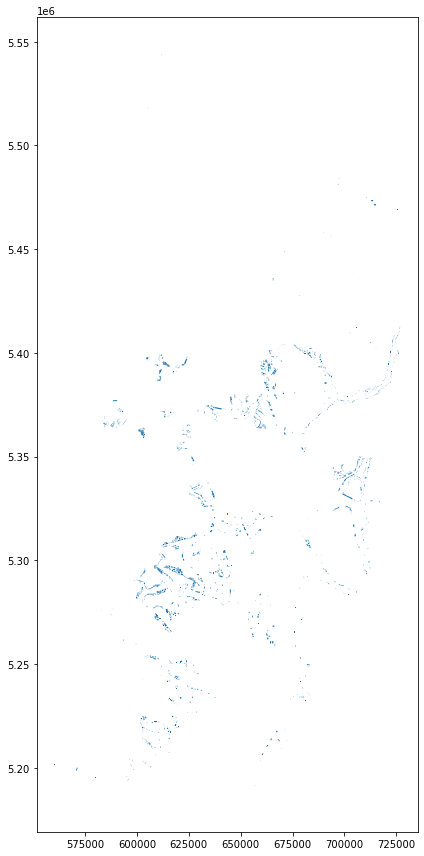

In [37]:
fig, ax = plt.subplots(figsize=(12,12))
CCAA.plot(ax=ax)
plt.tight_layout()
plt.show()

In [53]:

join_CCAA_ingresos = pd.merge(ingresos_filtered_final,CCAA , how='inner', left_on='Codigo Centro', right_on='REP_SUBPESCA2.ADM_UOT.PULLINQUE4_T_ACUICULTURA.N_CODIGOCENTRO')



In [54]:
join_CCAA_ingresos = gpd.GeoDataFrame(join_CCAA_ingresos)
join_CCAA_ingresos.to_file("../data/GIS/intermedios/CCAA_ingresos_8_meses.geojson", driver='GeoJSON')

### ingresos plantas y join con ubicacion (preguntar a nelson si pudo actualizarla)

In [67]:
reporte_plantas_filtered

,index,Año Declaración,Mes Declaración,Tipo Agente,Código Agente,Nombre Agente,Código Item,Nombre Item,Fecha Item,Tipo Origen,...,Nombre Origen,Código Ult. Proveedor,Nombre Ult. Proveedor,Fecha Ult. Proveedor,Toneladas Abastecidas,Toneladas Rest,Tipo Bodega,Dirección Bodega,Ciudad Bodega,Región Bodega
0,0,2021,ene.,Planta,3061,CAMANCHACA S.A.,456,ABALON ROJO,2021-01-05,CC,...,SECTOR I,30052,SECTOR I,2021-01-05,0.534,0.0,PLANTA,"Diego de Almeyda 1003, Caldera\n",Caldera,III REGION
1,1,2021,ene.,Planta,3061,CAMANCHACA S.A.,456,ABALON ROJO,2021-01-05,CC,...,SECTOR I,30052,SECTOR I,2021-01-05,0.521,0.0,PLANTA,"Diego de Almeyda 1003, Caldera\n",Caldera,III REGION
2,2,2021,ene.,Planta,3061,CAMANCHACA S.A.,456,ABALON ROJO,2021-01-05,CC,...,SECTOR I,30052,SECTOR I,2021-01-05,0.351,0.0,PLANTA,"Diego de Almeyda 1003, Caldera\n",Caldera,III REGION
3,3,2021,ene.,Planta,3061,CAMANCHACA S.A.,456,ABALON ROJO,2021-01-06,CC,...,SECTOR I,30052,SECTOR I,2021-01-06,0.542,0.0,PLANTA,"Diego de Almeyda 1003, Caldera\n",Caldera,III REGION
4,4,2021,ene.,Planta,3061,CAMANCHACA S.A.,456,ABALON ROJO,2021-01-06,CC,...,SECTOR I,30052,SECTOR I,2021-01-06,0.521,0.0,PLANTA,"Diego de Almeyda 1003, Caldera\n",Caldera,III REGION
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53969,54121,2022,jun.,Planta,13161,ALIMEX S.A.,435,CHORO,2022-06-19,CC,...,*,101664,*,2022-06-19,0.500,0.0,PLANTA,AVDA. LO ESPEJO 02635,Santiago,REGION METROPOLITANA
53970,54122,2022,jun.,Planta,13161,ALIMEX S.A.,425,CHOLGA,2022-06-21,CC,...,*,101664,*,2022-06-21,0.420,0.0,PLANTA,AVDA. LO ESPEJO 02635,Santiago,REGION METROPOLITANA
53971,54123,2022,jun.,Planta,13161,ALIMEX S.A.,430,CHORITO,2022-06-21,CC,...,*,101664,*,2022-06-21,0.920,0.0,PLANTA,AVDA. LO ESPEJO 02635,Santiago,REGION METROPOLITANA
53972,54124,2022,jun.,Planta,13161,ALIMEX S.A.,435,CHORO,2022-06-21,CC,...,*,101664,*,2022-06-21,0.480,0.0,PLANTA,AVDA. LO ESPEJO 02635,Santiago,REGION METROPOLITANA


In [88]:
date_today = pd.to_datetime('today')
# se define las fechas maximas y minimas a consultar
# end date es un año
end_date = date_today - timedelta(weeks=52)
# Se filtra para las fechas definidas anteriormente
reporte_plantas_filtered_final = reporte_plantas_filtered[(reporte_plantas_filtered['Fecha Item'] < pd.Timestamp(date_today)) & 
                                                      (reporte_plantas_filtered['Fecha Item'] > pd.Timestamp(end_date))]
reporte_plantas_filtered_final = reporte_plantas_filtered_final.groupby(['Nombre Agente','Código Agente'])['Toneladas Abastecidas'].agg('sum')
merge_plantas = pd.merge(reporte_plantas_filtered_final,
                                            listado_plantas, 
                                            how='inner', 
                                            left_on='Código Agente', 
                                            right_on='Cd_Planta')
merge_plantas
merge_plantas_noNulll = merge_plantas.dropna(subset=['X'])
reporte_plantas_filtered_final.shape

(35,)

In [89]:
merge_plantas_geo = gpd.GeoDataFrame(
    merge_plantas, geometry=gpd.points_from_xy(merge_plantas.X, merge_plantas.Y))
merge_plantas_geo.to_file("../data/GIS/intermedios/merge_plantas.geojson", driver='GeoJSON')